<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/1D_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Set-up**

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


**Set Locale to UTF-8**

In [ ]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


**Upgrade setuptools and pip**

In [ ]:
!pip install -U setuptools pip

**Install CuPy for CUDA 12.2**

In [ ]:
!pip install cupy-cuda12x

**Sample code to check GPU usage**

In [ ]:
import cupy as cp

# Check initial GPU memory usage
mempool = cp.get_default_memory_pool()
print("Initial GPU memory usage (bytes):", mempool.used_bytes())

# Create a large CuPy array on the GPU
size = 10**7  # Adjust size as needed to stress GPU
x = cp.random.random(size, dtype=cp.float32)

# Perform some GPU operations
y = x ** 9999999  # Square the elements
z = y.sum()  # Sum the elements

# Sync to ensure GPU computations are complete
cp.cuda.Device().synchronize()

# Check GPU memory usage after operations
print("Used GPU memory after computations (bytes):", mempool.used_bytes())

# Output the result of computation
print("Sum of squares:", z.get())  # Transfer result to CPU (NumPy)

Initial GPU memory usage (bytes): 0
Used GPU memory after computations (bytes): 120000512
Sum of squares: 1.0839877807485376


**Test cuda**

In [ ]:
import cupy as cp

# Check GPU memory usage
mempool = cp.get_default_memory_pool()
print("Used memory (bytes):", mempool.used_bytes())

Used memory (bytes): 120000512


**Check GPU memory usage dynamically**

In [ ]:
import cupy as cp

# Allocate a large array
x = cp.random.random((10**8,), dtype=cp.float32)  # Large array to stress GPU

# Check GPU memory usage
mempool = cp.get_default_memory_pool()
print("Used GPU memory (bytes):", mempool.used_bytes())

# Perform computations
y = x ** 2
z = cp.sum(y)

# Sync and check memory usage again
cp.cuda.Device().synchronize()
print("Used GPU memory after computations (bytes):", mempool.used_bytes())

Used GPU memory (bytes): 520000512
Used GPU memory after computations (bytes): 880001024


**Ensure CuPy is using the CUDA backend**

In [ ]:
# Check CUDA runtime version
print("CUDA runtime version:", cp.cuda.runtime.runtimeGetVersion())

CUDA runtime version: 12020


**Confirm GPU utilization**

In [ ]:
# !LC_ALL=C.UTF-8 nvidia-smi

**Rough-work 1**

In [ ]:
import numpy as np
import cupy as cp
import matplotlib as plt

x_data = [0, 1, 2, 3, 4, 5]
num_dp = 6

degree = 3
num_coef = degree + 1

G = cp.array([[x**i for i in range(num_coef)] for x in x_data])
H = cp.array([[x**i for i in range(num_coef)] for x in x_data])

A = []
b = []

for i in range(num_dp):
  constraint_1 = cp.zeros(2 * num_coef + 1)
  constraint_1[0:num_coef] = -G[i]
  A.append(constraint_1)
  b.append(0)

print(f"G: {G}")
print(f"H: {H}")
print(f"A: {A}")
print(f"b: {b}")

from scipy.optimize import linprog
c = [-1, 4]
A = [[-3, 1], [1, 2]]


G: [[  1   0   0   0]
 [  1   1   1   1]
 [  1   2   4   8]
 [  1   3   9  27]
 [  1   4  16  64]
 [  1   5  25 125]]
H: [[  1   0   0   0]
 [  1   1   1   1]
 [  1   2   4   8]
 [  1   3   9  27]
 [  1   4  16  64]
 [  1   5  25 125]]
A: [array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([-1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.]), array([-1., -2., -4., -8.,  0.,  0.,  0.,  0.,  0.]), array([ -1.,  -3.,  -9., -27.,   0.,   0.,   0.,   0.,   0.]), array([ -1.,  -4., -16., -64.,   0.,   0.,   0.,   0.,   0.]), array([  -1.,   -5.,  -25., -125.,    0.,    0.,    0.,    0.,    0.])]
b: [0, 0, 0, 0, 0, 0]


**Rough-work 2**

In [ ]:
from scipy.optimize import linprog

c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]

x0_bounds = (None, None)
x1_bounds = (-3, None)

t = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds])

print(f"t =", t)

t =         message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -22.0
              x: [ 1.000e+01 -3.000e+00]
            nit: 0
          lower:  residual: [       inf  0.000e+00]
                 marginals: [ 0.000e+00  6.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 3.900e+01  0.000e+00]
                 marginals: [-0.000e+00 -1.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


**Training**

Number of Iterations: 27
z Values in all Iterations: [50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.048828125, 0.0244140625, 0.01220703125, 0.006103515625, 0.0030517578125, 0.00152587890625, 0.000762939453125, 0.0003814697265625, 0.00019073486328125, 9.5367431640625e-05, 4.76837158203125e-05, 2.384185791015625e-05, 1.1920928955078125e-05, 5.9604644775390625e-06, 2.9802322387695312e-06, 1.4901161193847656e-06, 7.450580596923828e-07]
Optimal z (Maximum Deviation): 7.450580596923828e-07


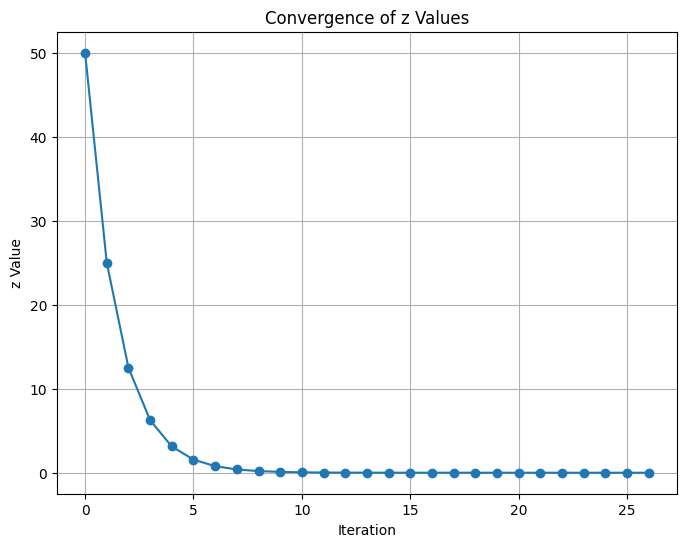

Optimized Coefficients (Numerator α): [5.78036938e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.67114035e-04 0.00000000e+00 6.96735086e-03 9.13303356e-05
 9.59465186e-03 1.96022933e-05 2.52611224e-03 0.00000000e+00
 9.87251509e-05]
Optimized Coefficients (Denominator β): [1.37941074e-06 1.46054829e-05 1.16046586e-04 2.99614264e-04
 3.15309166e-03 1.07584315e-03 1.01475294e-02 6.67957363e-04
 6.08079698e-03 6.89331796e-05 6.61614639e-04 6.12290202e-07
 6.39087130e-06]
Optimal θ: 7.673135465749539e-08


In [ ]:
import cupy as cp
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Target function
def target_function(x):
    return cp.abs(x - 0.1)

# Rational function | r(x) = (α_0 + α_1*x + ...)/(β_0 + β_1*x + ...)
def rational_function(x, alpha, beta):
    # Numerator polynomial
    numerator = sum(alpha[i] * x**i for i in range(len(alpha)))
    # Denominator polynomial
    denominator = sum(beta[i] * x**i for i in range(len(beta)))
    return numerator / denominator

delta = 1e-6 # a small +ve value for constraint_3

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data, degree):
    num_data_points = len(x_data)
    num_coefficients = degree + 1  # Number of coefficients for num & den

    # Construct the G(x) & H(x) polynomials
    # Numerator polynomial
    G = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])
    # Denominator polynomial
    H = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z    #UB(X)
        f_minus_z = y_data[i] - z   #LB

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        # (-G(xi))αT + (f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # (2) Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) - (f(xi) - z) * β^T H(xi) ≤ θ
        # G(xi).αT + (-1)(f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # (2) Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        # (0)α^T + (-H(x)) β^T + (0)θ ≤ -δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficients of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # print(f"A: {A[0]}")

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"A: {A[0]}")
    # print(f"len(A[0]): {len(A[0])}")
    # print(f"len(b): {len(b)}")

    #for linprog API -
    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None

# Bisection loop
def bisection_loop(x_data, y_data, degree, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data, degree)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Main execution
if __name__ == "__main__":
    # Data setup
    degree = 12  # Polynomial degree
    x_data = cp.linspace(-3, 3, 100)  # Discretized data points
    y_data = target_function(x_data)  # Target values

    # Initial coefficients for the rational function
    # alpha_initial = [5, 3, 2]  # Coefficients of numerator
    # beta_initial = [7, 4, 3]   # Coefficients of denominator

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 100  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_data, y_data, degree, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # Plot convergence of z values
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("z Value")
    plt.title("Convergence of z Values")
    plt.grid(True)
    plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")

**Testing**

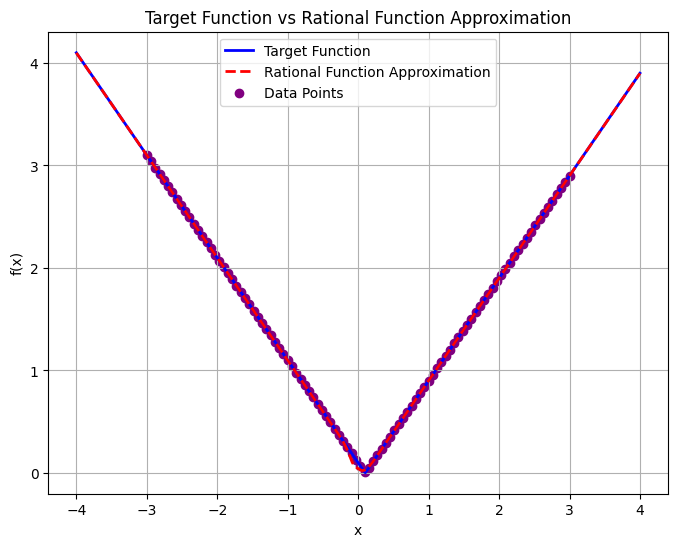

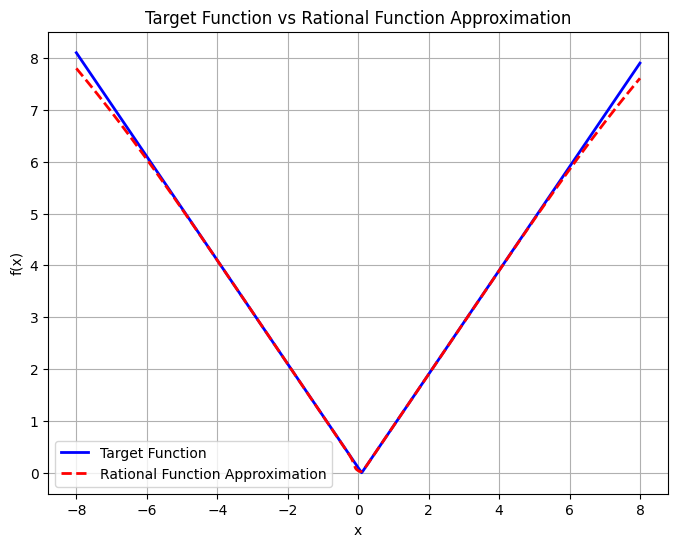

In [ ]:
import matplotlib.pyplot as plt

# Close-up
def plot_functions(target_function, rational_function, alpha, beta, x_range):
    # Generate points for the plot
    x_test = cp.linspace(x_range[0], x_range[1], 900)  # Use CuPy for GPU computations
    y_target = target_function(x_test)  # Compute the target function values
    y_rational = cp.array([rational_function(x, alpha, beta) for x in x_test])  # Compute rational function values

    # Convert CuPy arrays to NumPy for plotting
    x_test = cp.asnumpy(x_test)
    y_target = cp.asnumpy(y_target)
    y_rational = cp.asnumpy(y_rational)

    # Plot the functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
    plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
    plt.scatter(cp.asnumpy(x_data), cp.asnumpy(y_data), label="Data Points", color="purple", marker="o")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Target Function vs Rational Function Approximation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution for plotting
if __name__ == "__main__":
    # Test points range for plotting
    x_range = [-4, 4]

    # Call the plotting function
    plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_range)

# Bigger range
def plot_functions(target_function, rational_function, alpha, beta, x_range):
    # Generate points for the plot
    x_test = cp.linspace(x_range[0], x_range[1], 900)  # Use CuPy for GPU computations
    y_target = target_function(x_test)  # Compute the target function values
    y_rational = cp.array([rational_function(x, alpha, beta) for x in x_test])  # Compute rational function values

    # Convert CuPy arrays to NumPy for plotting
    x_test = cp.asnumpy(x_test)
    y_target = cp.asnumpy(y_target)
    y_rational = cp.asnumpy(y_rational)

    # Plot the functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
    plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
    # plt.scatter(cp.asnumpy(x_data), cp.asnumpy(y_data), label="Data Points", color="purple", marker="o")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Target Function vs Rational Function Approximation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution for plotting
if __name__ == "__main__":
    # Test points range for plotting
    x_range = [-8, 8]

    # Call the plotting function
    plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_range)

**4-d**

G: [[   1    1    1    1    1    2    3    4    1    4    9   16    1    8
    27   64    1   16   81  256]
 [   1    1    1    1    2    3    4    5    4    9   16   25    8   27
    64  125   16   81  256  625]
 [   1    1    1    1    3    4    5    6    9   16   25   36   27   64
   125  216   81  256  625 1296]
 [   1    1    1    1    2    4    5    9    4   16   25   81    8   64
   125  729   16  256  625 6561]
 [   1    1    1    1    3    4    8    9    9   16   64   81   27   64
   512  729   81  256 4096 6561]]
H: [[   1    1    1    1    1    2    3    4    1    4    9   16    1    8
    27   64    1   16   81  256]
 [   1    1    1    1    2    3    4    5    4    9   16   25    8   27
    64  125   16   81  256  625]
 [   1    1    1    1    3    4    5    6    9   16   25   36   27   64
   125  216   81  256  625 1296]
 [   1    1    1    1    2    4    5    9    4   16   25   81    8   64
   125  729   16  256  625 6561]
 [   1    1    1    1    3    4    8    9    9  

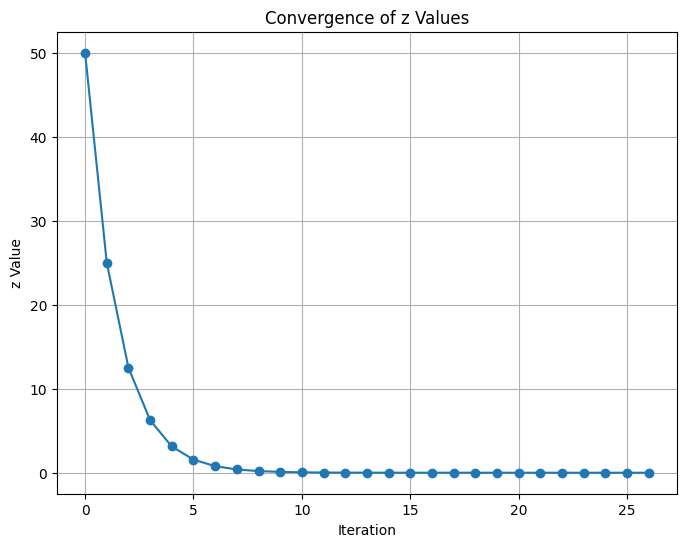

Optimized Coefficients (Numerator α): [6.50899052e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.11232673e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.31716866e-09 4.57809119e-09]
Optimized Coefficients (Denominator β): [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.49046701e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.81319630e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Optimal θ: 0.0


In [5]:
import cupy as cp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Target function (explicit and simple definition)
def target_function(x):
    """
    Target function: |x1 + x2 + x3 + x4 - 0.1|.
    x is a vector of 4 variables for each data point.
    """
    return cp.abs(x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3] - 0.1)


# Rational function (explicit definition for 4 variables)
def rational_function(x, alpha, beta):
    """
    Rational function:
    r(x) = (α_0 + α_1*x1 + α_2*x2 + α_3*x3 + α_4*x4) /
           (β_0 + β_1*x1 + β_2*x2 + β_3*x3 + β_4*x4).

    x is a vector of 4 variables for each data point.
    alpha and beta are the coefficients of the numerator and denominator.
    """
    # Numerator polynomial
    numerator = alpha[0] + alpha[1] * x[:, 0] + alpha[2] * x[:, 1] + alpha[3] * x[:, 2] + alpha[4] * x[:, 3]

    # Denominator polynomial
    denominator = beta[0] + beta[1] * x[:, 0] + beta[2] * x[:, 1] + beta[3] * x[:, 2] + beta[4] * x[:, 3]

    return numerator / denominator

delta = 1e-6  # A small positive value for the 3rd constraint

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data, degree, num_variables):
    num_data_points = x_data.shape[0]
    num_coefficients = (degree + 1) * num_variables #num_variables + 1  # Total coefficients for numerator & denominator

    # Construct the G(x) and H(x) polynomials for multivariate input
    G = cp.hstack([x_data**i for i in range(degree + 1)])  # Numerator polynomial
    H = cp.hstack([x_data**i for i in range(degree + 1)])  # Denominator polynomial

    print(f"G: {G}")
    print(f"H: {H}")

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z  # Upper bound
        f_minus_z = y_data[i] - z  # Lower bound

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # Coefficient of θ
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) - (f(xi) - z) * β^T H(xi) ≤ θ
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_minus_z) * H[i]
        # Coefficient of θ
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficients of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"matrix A[0]: {A[0]}")
    print(f"len(A[0]): {len(A[0])}")
    print(f"len(b): {len(b)}")

    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None


# Bisection loop
def bisection_loop(x_data, y_data, degree, num_variables, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data, degree, num_variables)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Main execution
if __name__ == "__main__":
    # Data setup
    num_variables = 4  # Number of variables
    degree = 4  # Polynomial degree
    x_data = cp.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [2, 4, 5, 9], [3, 4, 8, 9]])  # Multivariate input
    y_data = target_function(x_data)  # Target values

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 100  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_data, y_data, degree, num_variables, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # Plot convergence of z values
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("z Value")
    plt.title("Convergence of z Values")
    plt.grid(True)
    plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")

**Rough-work**

In [13]:
import cupy as cp
import numpy as np
from scipy.optimize import linprog

x_data = cp.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [2, 4, 5, 9], [3, 4, 8, 9]])
num_data_points = 5
num_coefficients = 5

# G = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])
# H = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])

# G = cp.hstack([x_data for i in range(num_coefficients)])
# H = cp.hstack([x_data for i in range(num_coefficients)])

G = cp.zeros((num_data_points, num_coefficients))
H = cp.zeros((num_data_points, num_coefficients))

for i in range(num_data_points):
  G[i, 0] = 1
  H[i, 0] = 1
  for j in range(0, num_coefficients):
    G[i, j] = x_data[i, j - 1] ** j
    H[i, j] = x_data[i, j - 1] ** j

print(f"G =", G)
print(f"H =", H)

G = [[1.000e+00 1.000e+00 4.000e+00 2.700e+01 2.560e+02]
 [1.000e+00 2.000e+00 9.000e+00 6.400e+01 6.250e+02]
 [1.000e+00 3.000e+00 1.600e+01 1.250e+02 1.296e+03]
 [1.000e+00 2.000e+00 1.600e+01 1.250e+02 6.561e+03]
 [1.000e+00 3.000e+00 1.600e+01 5.120e+02 6.561e+03]]
H = [[1.000e+00 1.000e+00 4.000e+00 2.700e+01 2.560e+02]
 [1.000e+00 2.000e+00 9.000e+00 6.400e+01 6.250e+02]
 [1.000e+00 3.000e+00 1.600e+01 1.250e+02 1.296e+03]
 [1.000e+00 2.000e+00 1.600e+01 1.250e+02 6.561e+03]
 [1.000e+00 3.000e+00 1.600e+01 5.120e+02 6.561e+03]]
